# Student's Mask Detector
An AI system that will check for the students in the class who are not wearing mask and will notify it to the authorities
> To create this project we need to do a few steps
- Problem Scoping
- Data Cleaning
- Modeling
- Testing 
- The Main Student's mask detection system

## 00. Problem Scoping

![COTM](./Assets/COTM2.png)
By [AI Students Communtiy](https://aistudent.community), event [COTM](https://aistudent.community/single_event/12)
<hr>

**Problem**: Your school has begun with many strict measures to ensure safety of all the students. Safe distance is to be maintained, everyone should wear a mask, etc. but while everyone is expected to take measures to stay safe, it is noticed that many students take off their masks in the classroom, usually in the absence of any teacher.
<hr>

**Challenge**: You are called by your school authorities to use your AI skills to build a model to detect names of students who are not wearing their masks properly in the classrooms, with other features that you feel are important to maintain safety in the classroom environment.

#### To Solve this challange Our programme should
1. Detect Faces
2. Detect if that face is wearing a mask or not
3. Take a screenshot of the face or crop the face from the webcam feed and send it through mail

## Imports

In [1]:
# Standard Imports
%matplotlib inline
import numpy as np
import cv2 
import os
import matplotlib.pyplot as plt

In [2]:
# importing function to split the data
from sklearn.model_selection import train_test_split

In [3]:
# Imports for preprocessing the data
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

In [4]:
# Imports for making of the Model
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Dropout, Flatten
from keras.optimizers import Adam

In [5]:
# Import for loding the saved model
from keras.models import load_model

## Defining the Constants

In [6]:
# Constants
DATASET_PATH = './Dataset'
IMAGE_SIZE = 32  # To convert the Image into size 32 x 32 px

TEST_RATIO = 0.2
VAL_RATIO = 0.2 # Validation ratio

# Model constants
BATCH_SIZE = 50
EPOCHS = 25
MODEL_PATH = './Data/onefile_mask_detection_model.model' 

THRESHOLD = 0.90  # only if the model is sure more than 90% then only give the prediction

WITHOUT_MASK = 1

In [7]:
AUTHORITY_EMAIL = None
MY_MAIL = None
PASSWORD = None

# 01. Data Cleaning
### First let us start with making a model which will detect if theh face is wearing a mask or not
**To create this we need to clearn our data so that it is uniform and will give us the optimum results**

## The Dataset used is a subpart of [Face Mask ~12K Images Dataset by Ashish Jangra on Kaggle](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset)
### We are using approx. 4,000 Images form the dataset

In [8]:
images = []
class_no = []

In [9]:
# Getting the classes form the dataset
classes = os.listdir(DATASET_PATH)
classes

['WithMask', 'WithoutMask']

### Importing the Dataset

In [10]:
print("[+] Importing the Classes...")

for i, class_ in enumerate(classes):
    # Get the names of all the pictures in the class
    image_name_list = os.listdir(DATASET_PATH + "/" + class_)
    
    # Read every image in the class
    for image_name in image_name_list:
        img = cv2.imread(DATASET_PATH + "/" + class_ + "/" + image_name)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        
        # add the image and class(as a number) to the data list
        images.append(img)
        class_no.append(i)
        
    print(f"[+] Imported {class_} or {i} class")

[+] Importing the Classes...
[+] Imported WithMask or 0 class
[+] Imported WithoutMask or 1 class


Converting these lists into np.array

In [11]:
images = np.array(images)
class_no = np.array(class_no)

In [12]:
# Checking for the data length and unique classes
len(images), len(class_no), np.unique(class_no)

(4024, 4024, array([0, 1]))

Used _stackoverflow_ to get the unique `values` and their `counts`, [Question link](https://stackoverflow.com/a/25943480) 

In [13]:
values, counts = np.unique(class_no, return_counts=True)

### Plotting the number of data for each classes

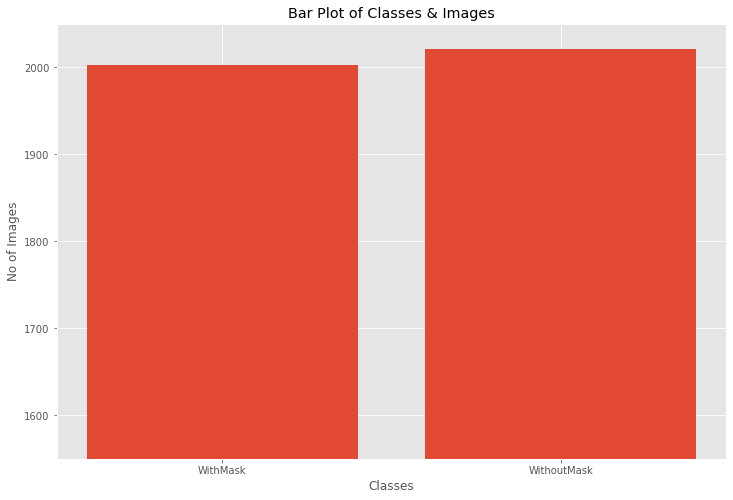

In [14]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(values, counts, tick_label=classes)
ax.set(
    title="Bar Plot of Classes & Images",
    xlabel="Classes",
    ylabel="No of Images",
    ylim=[1550, 2050]
)

plt.show()

## Data is converted

<hr>
<hr>

# 02. Modeling

We need to create a Model which will **_classify_** between **faces wearing mask** and **faces not wearing mask**
![face with mask and face without mask](./Assets/mask_no_mask.png)

###### As our problem is of classification we will have to make a Deep learning classification Neural Network model 

In [15]:
number_of_classes = len(np.unique(class_no)) # Getting the total number of unique classes
number_of_classes

2

### Spliting the data into train, test and validation set
`X` are the features and `y` is the target

In [16]:
X_train, X_test, y_train, y_test = train_test_split(images, class_no, test_size=TEST_RATIO)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=VAL_RATIO)

# checking the shapes of the data
print(f"Train set -> X: {X_train.shape}, y: {y_train.shape}")
print(f"Test set -> X: {X_test.shape}, y: {y_test.shape}")
print(f"Validation set -> X: {X_validation.shape}, y: {y_validation.shape}")

Train set -> X: (2575, 32, 32, 3), y: (2575,)
Test set -> X: (805, 32, 32, 3), y: (805,)
Validation set -> X: (644, 32, 32, 3), y: (644,)


### Before we make the model, we should:
- Reshape the sets to the needed shape
- Increase the contrast of the image for better results using [cv2.equalizeHist()](https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html)
- Convert the integer values to float values between 0 and 1
- And also make sure they all are also grey for good results
- The target array should be categorical 

In [17]:
# defining a function to preprocess the images
def preprocess_image(image):
    """Takes an image and returns the preprocesses version of it."""
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image = cv2.equalizeHist(image)  # Increasing the contrast of the image
    
    image = image / 255  # converting the image to float
    
    return image

In [18]:
# Preprocessing the Images
X_train = np.array(list(map(preprocess_image, X_train)))
X_test = np.array(list(map(preprocess_image, X_test)))
X_validation = np.array(list(map(preprocess_image, X_validation)))

# Reshaping the sets
# the new shape should be (previous_shape[0], previous_shape[0], previous_shape[0], 1)  
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)

In [19]:
# turning the y sets (target sets) into categorical arays
# using a built in function in keras for one-hot-encoding the sets
y_train = to_categorical(y_train, number_of_classes)
y_test = to_categorical(y_test, number_of_classes)
y_validation = to_categorical(y_validation, number_of_classes)

In [20]:
# using Image data augmentation 
# Image data argumentation is a technique that can be used to artificially expand the size of a 
# training dataset by creating modified versions of images in the dataset 

# creating the ImageDataGenerator object
data_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10
)

In [21]:
# generation and fiting the train images
data_gen.fit(X_train)

## Making the ML Model to classify between Mask and No-Mask images

In [22]:
size_of_filter = (3, 3)
size_of_pool = (2, 2)

# Making the layers
model = Sequential()
model.add((Conv2D(32, size_of_filter, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation='relu')))
model.add((Conv2D(32, size_of_filter, activation='relu')))
model.add(MaxPooling2D(pool_size=size_of_pool))

model.add((Conv2D(64, size_of_filter, activation='relu')))
model.add((Conv2D(64, size_of_filter, activation='relu')))
model.add(MaxPooling2D(pool_size=size_of_pool))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(number_of_classes, activation='softmax'))
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0

### Fitting the data into the model

In [23]:
history = model.fit(
    data_gen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (X_validation, y_validation),
    shuffle = 1
)

Epoch 1/25
51/51 [==============================] - 10s 163ms/step - loss: 0.6918 - accuracy: 0.5161 - val_loss: 0.6289 - val_accuracy: 0.7050
Epoch 2/25
51/51 [==============================] - 5s 104ms/step - loss: 0.5930 - accuracy: 0.6920 - val_loss: 0.3492 - val_accuracy: 0.8354
Epoch 3/25
51/51 [==============================] - 5s 97ms/step - loss: 0.4310 - accuracy: 0.8028 - val_loss: 0.2723 - val_accuracy: 0.8758
Epoch 4/25
51/51 [==============================] - 8s 157ms/step - loss: 0.3480 - accuracy: 0.8460 - val_loss: 0.1480 - val_accuracy: 0.9472
Epoch 5/25
51/51 [==============================] - 7s 128ms/step - loss: 0.3074 - accuracy: 0.8727 - val_loss: 0.1169 - val_accuracy: 0.9581
Epoch 6/25
51/51 [==============================] - 6s 126ms/step - loss: 0.2630 - accuracy: 0.8928 - val_loss: 0.1421 - val_accuracy: 0.9394
Epoch 7/25
51/51 [==============================] - 6s 127ms/step - loss: 0.2300 - accuracy: 0.9007 - val_loss: 0.0976 - val_accuracy: 0.9612
Epoch 

### Plotting the Training loss and the accuracy of the model

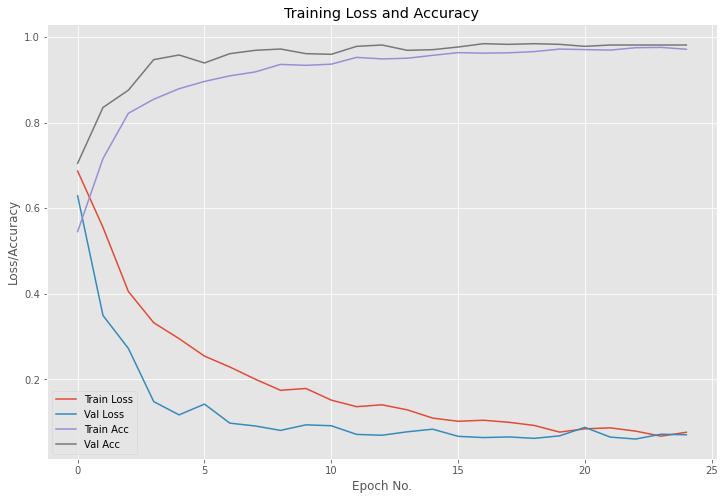

In [24]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(12, 8))

x_axis = np.arange(0, EPOCHS)

ax.plot(x_axis, history.history['loss'], label="Train Loss")
ax.plot(x_axis, history.history['val_loss'], label="Val Loss")
ax.plot(x_axis, history.history['accuracy'], label="Train Acc")
ax.plot(x_axis, history.history['val_accuracy'], label="Val Acc")

ax.set(
    title = "Training Loss and Accuracy",
    xlabel = "Epoch No.",
    ylabel = "Loss/Accuracy"
)

ax.legend(loc="lower left")

plt.show()

## Evaluating the Model

In [25]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 0s 18ms/step - loss: 0.0688 - accuracy: 0.9863


[0.06883474439382553, 0.9863353967666626]

## Saving the Model

In [26]:
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: ./Data/onefile_mask_detection_model.model\assets


#### Our Model has 98.88% accuracy, let's test it!
<hr>
<hr>

# 03. Testing

In [27]:
model = load_model(MODEL_PATH)

In [28]:
face_detector = cv2.CascadeClassifier('./Data/haarcascade_frontalface_default.xml')

In [29]:
# specific constants
GREEN = (0, 255, 0)  # Green Color
RED = (50, 50, 255)  # Red Color
FONT = cv2.FONT_HERSHEY_COMPLEX
WITH_MASK = 0
WITHOUT_MASK = 1

In [30]:
def highlight_face(image, color, text, x, y, w, h):
    cv2.rectangle(image, (x, y), (x+w, y+h), color, 5)
    cv2.rectangle(image, (x, y-40), (x+w, y), color, -2)
    cv2.putText(
        image,
        text,
        (x, y-10),
        FONT, 0.75,
        (255, 255, 255),
        1, cv2.LINE_AA
    )

### Taking the feed from webcam and checking if the faces in that feed are wearing a mask or not

In [ ]:
webcam = cv2.VideoCapture(0)

# run until 'q' or 'Q' is pressed
while True:
    sucess, frame = webcam.read()  # Read the current frame
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Converting the image to grey for better face recognition
    faces = face_detector.detectMultiScale(frame_gray, 1.3, 5)  # Detect for faces in the current frame
    
    for x, y, w, h in faces: # for x_cor, y_cor, width, height of every face
        crop_img = frame[y: y+h, x: x+h]  # crop the frame just to the face using list slicing
        img = cv2.resize(crop_img, (IMAGE_SIZE, IMAGE_SIZE)) # Resize the Image to the dimensions
        img = preprocess_image(img)  
        img = img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1)  
        
        # Pridict for the face (if it is wearing mask or not)
        prediction = model.predict(img)
        class_ = np.argmax(prediction)  # getting the index of the hightes prediction
        probability = np.max(prediction)
        
        if probability >= THRESHOLD:
            if class_ == WITH_MASK:  # If the face has mask display 'Mask' with green rectangle
                highlight_face(frame, GREEN, 'Mask', x, y, w, h)
            elif class_ == WITHOUT_MASK:  # If the face does not have mask display 'No Mask' with red rectangle
                highlight_face(frame, RED, 'No Mask', x, y, w, h)
                
    cv2.imshow("Webcam", frame)
    key = cv2.waitKey(1) # wait for 1 milisecond and capture the key if any pressedf
    if key == ord('q') or key == ord('Q'):
        break
        
webcam.release()
cv2.destroyAllWindows()

The output of this cell of code is 
![demo](./Assets/model-demo.gif)

### Let us send an email if the student is not wearing a mask

In [ ]:
import smtplib
from email.message import EmailMessage

In [ ]:
def get_binary(img):
    cv2.imwrite('./Data/temp.png', img)
    
    with open('./Data/temp.png', 'rb') as image:
        content = image.read()
    
    os.remove('./Data/temp.png')
    return content

def send_email(image):
    email = EmailMessage()
    email['to'] = AUTHORITY_EMAIL
    email['Subject'] = 'A Student not wearing a mask'
    email['from'] = 'Mask Detector AI'
    
    email.set_content('I found A Student who is not wearing a Mask')
    
    email.add_attachment(get_binary(image), maintype='image', subtype='png', filename='student.png')
    
    if MY_MAIL is None or PASSWORD is None or AUTHORITY_MAIL is None:
        print('[Error] No Credentials providen, Please go to the top of this file and fill out the credentials in the constants')
    
    with smtplib.SMTP(host='smtp.gmail.com', port=587) as smtp:
        smtp.ehlo()
        smtp.starttls()
        
        while True:
            try:
                smtp.login(MY_MAIL, PASSWORD)
                smtp.send_message(email)
                print("Done!!!")
                break
            except:
                print("There was a problem while login try again or check if this program is allowed to use the mail services")

#### Check for students in a frame which are not wearing a mask and then mail to the authority
We are checking here in only 1 frame as if we check in feed teh same student will be reported in every frame and will create a lot of useless amils

In [ ]:
webcam = cv2.VideoCapture(0)

sucess, frame = webcam.read()  # Read the current frame
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Converting the image to grey for better face recognition
faces = face_detector.detectMultiScale(frame_gray, 1.3, 5)  # Detect for faces in the current frame

for x, y, w, h in faces: # for x_cor, y_cor, width, height of every face
    crop_img = frame[y: y+h, x: x+h]  # crop the frame just to the face using list slicing
    img = cv2.resize(crop_img, (IMAGE_SIZE, IMAGE_SIZE)) # Resize the Image to the dimensions
    img = preprocess_image(img)  
    img = img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1)  

    # Pridict for the face (if it is wearing mask or not)
    prediction = model.predict(img)
    class_ = np.argmax(prediction)  # getting the index of the hightes prediction
    probability = np.max(prediction)

    if probability >= THRESHOLD:
        if class_ == WITHOUT_MASK:  # If the face does not have mask mail to authority
            send_email(crop_img)
            highlight_face(frame, RED, 'No Mask', x, y, w, h)

cv2.imshow("Webcam", frame)
cv2.waitKey(0)
webcam.release()

This is the screenshot of the mail sent by this app
![email sent by the above cell of code](./Assets/mail_by_onefile.png)

# Done!